# Pitch Classification - Oversample
Here, I am going to try oversampling to try to improve the performance of my model.

Importing various packages:

In [1]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Pickling in the main dataframe, train_df_clusters.pickle from Pitch_Classification_Intro.ipynb:

In [4]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [5]:
with open('../Data/train_df_clusters.pickle','rb') as read_file:
    pitch_df = pickle.load(read_file)

In [6]:
pitch_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate,Name,Cluster
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0


In [7]:
pitch_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
       'Name', 'Cluster'],
      dtype='object')

In [8]:
pitch_df.Season.value_counts()

2018    730569
2017    728204
2016    711832
2015    699767
Name: Season, dtype: int64

In order to help run the class imbalance on a multi-class set like this, I'll be utilizing a SMOTE system, using [this site](https://machinelearningmastery.com/multi-class-imbalanced-classification/) as a guide.

Importing functions to utilize in model building:

In [9]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [10]:
from location_regression_functions import *
from pitch_cat_functions import *

Bringing in class imbalance package:

In [11]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [12]:
from collections import Counter

For this first example, I'll be utilizing Max Scherzer again, in order to compare to the results in Pitch_Classification_Intro.ipynb.

In [13]:
scherzer_df = pitch_df[(pitch_df.pitcher_full_name == 'Max Scherzer') &(pitch_df.last_pitch_px.notnull())]

### One-Hot Encoding:

In [14]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type', 'Cluster']

In [15]:
ohe_df = column_ohe_maker(scherzer_df, ohe_cols)

### Number Encoding Pitch Type Column:

In [16]:
output_df = pitch_type_to_num(ohe_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate', 'Name', 'stand_R', 'last_pitch_type_CU',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'Cluster_1.0',
       'Cluster_2.0', 'Cluster_3.0', 'Cluster_4.0', 'Pi

In [18]:
col = ['Cluster_1.0',
       'Cluster_2.0', 'Cluster_3.0', 'Cluster_4.0','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

## Class Imbalance

Here, I'll begin working on the class imbalance problem, with the dataframe now formatted right.

In [19]:
scherzer_counts = output_df.pitch_type.value_counts()

Plotting to visually see:

Text(0.5, 1.0, 'Max Scherzer Pitch Counts, 2015-2018')

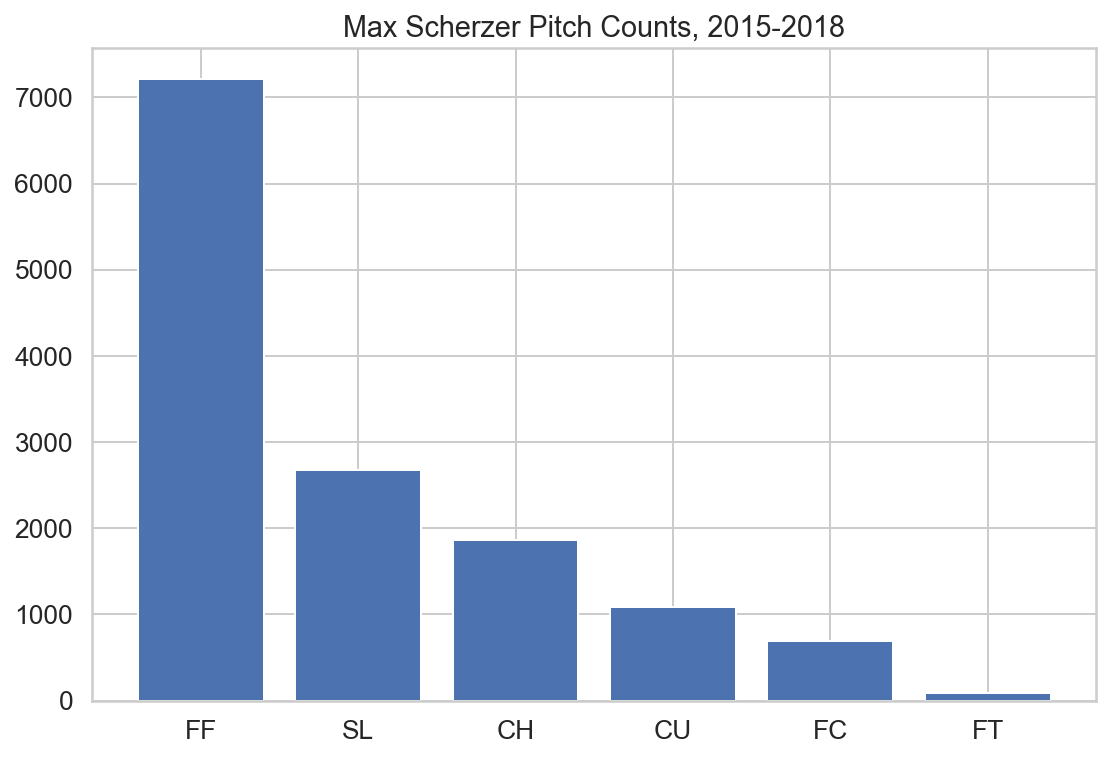

In [20]:
plt.bar(scherzer_counts.index, scherzer_counts)
plt.title('Max Scherzer Pitch Counts, 2015-2018')

In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
X = output_df[col]

In [23]:
y = output_df['Pitch_Type_Num']

Utilizing a function built out in pitch_cat_functions.py, which oversamples the minority classes in the train set:

Random Forest Results for Max Scherzer
Precision scores: [0.3048612606069969]
Mean Precision: 0.3048612606069969
Confusion Matrix for Fold 1
[[1047  219   80   62   35    3]
 [ 314  193   15    6    5    3]
 [ 241   42   31   26   35    0]
 [ 142    8   14   21    9    0]
 [  90    1   22   10   28    0]
 [   4   10    3    0    2    2]]


Precision scores: [0.3048612606069969, 0.2846746035160568]
Mean Precision: 0.29476793206152685
Confusion Matrix for Fold 2
[[973 242  83  62  47   3]
 [314 187  17   2   2   6]
 [269  45  37  19  26   2]
 [159   6  18  28  17   1]
 [ 83   2  20  10  24   0]
 [  9   3   1   3   1   2]]


Precision scores: [0.3048612606069969, 0.2846746035160568, 0.33552427934248574]
Mean Precision: 0.3083533811551798
Confusion Matrix for Fold 3
[[1018  224  100   62   51    6]
 [ 290  212   12    4    3    1]
 [ 251   52   44   17   30    1]
 [ 142    6   18   27    8    2]
 [  55    6   19   10   29    0]
 [   4   10    1    1    2    5]]


Precision scores: [0.30486

RandomForestClassifier()

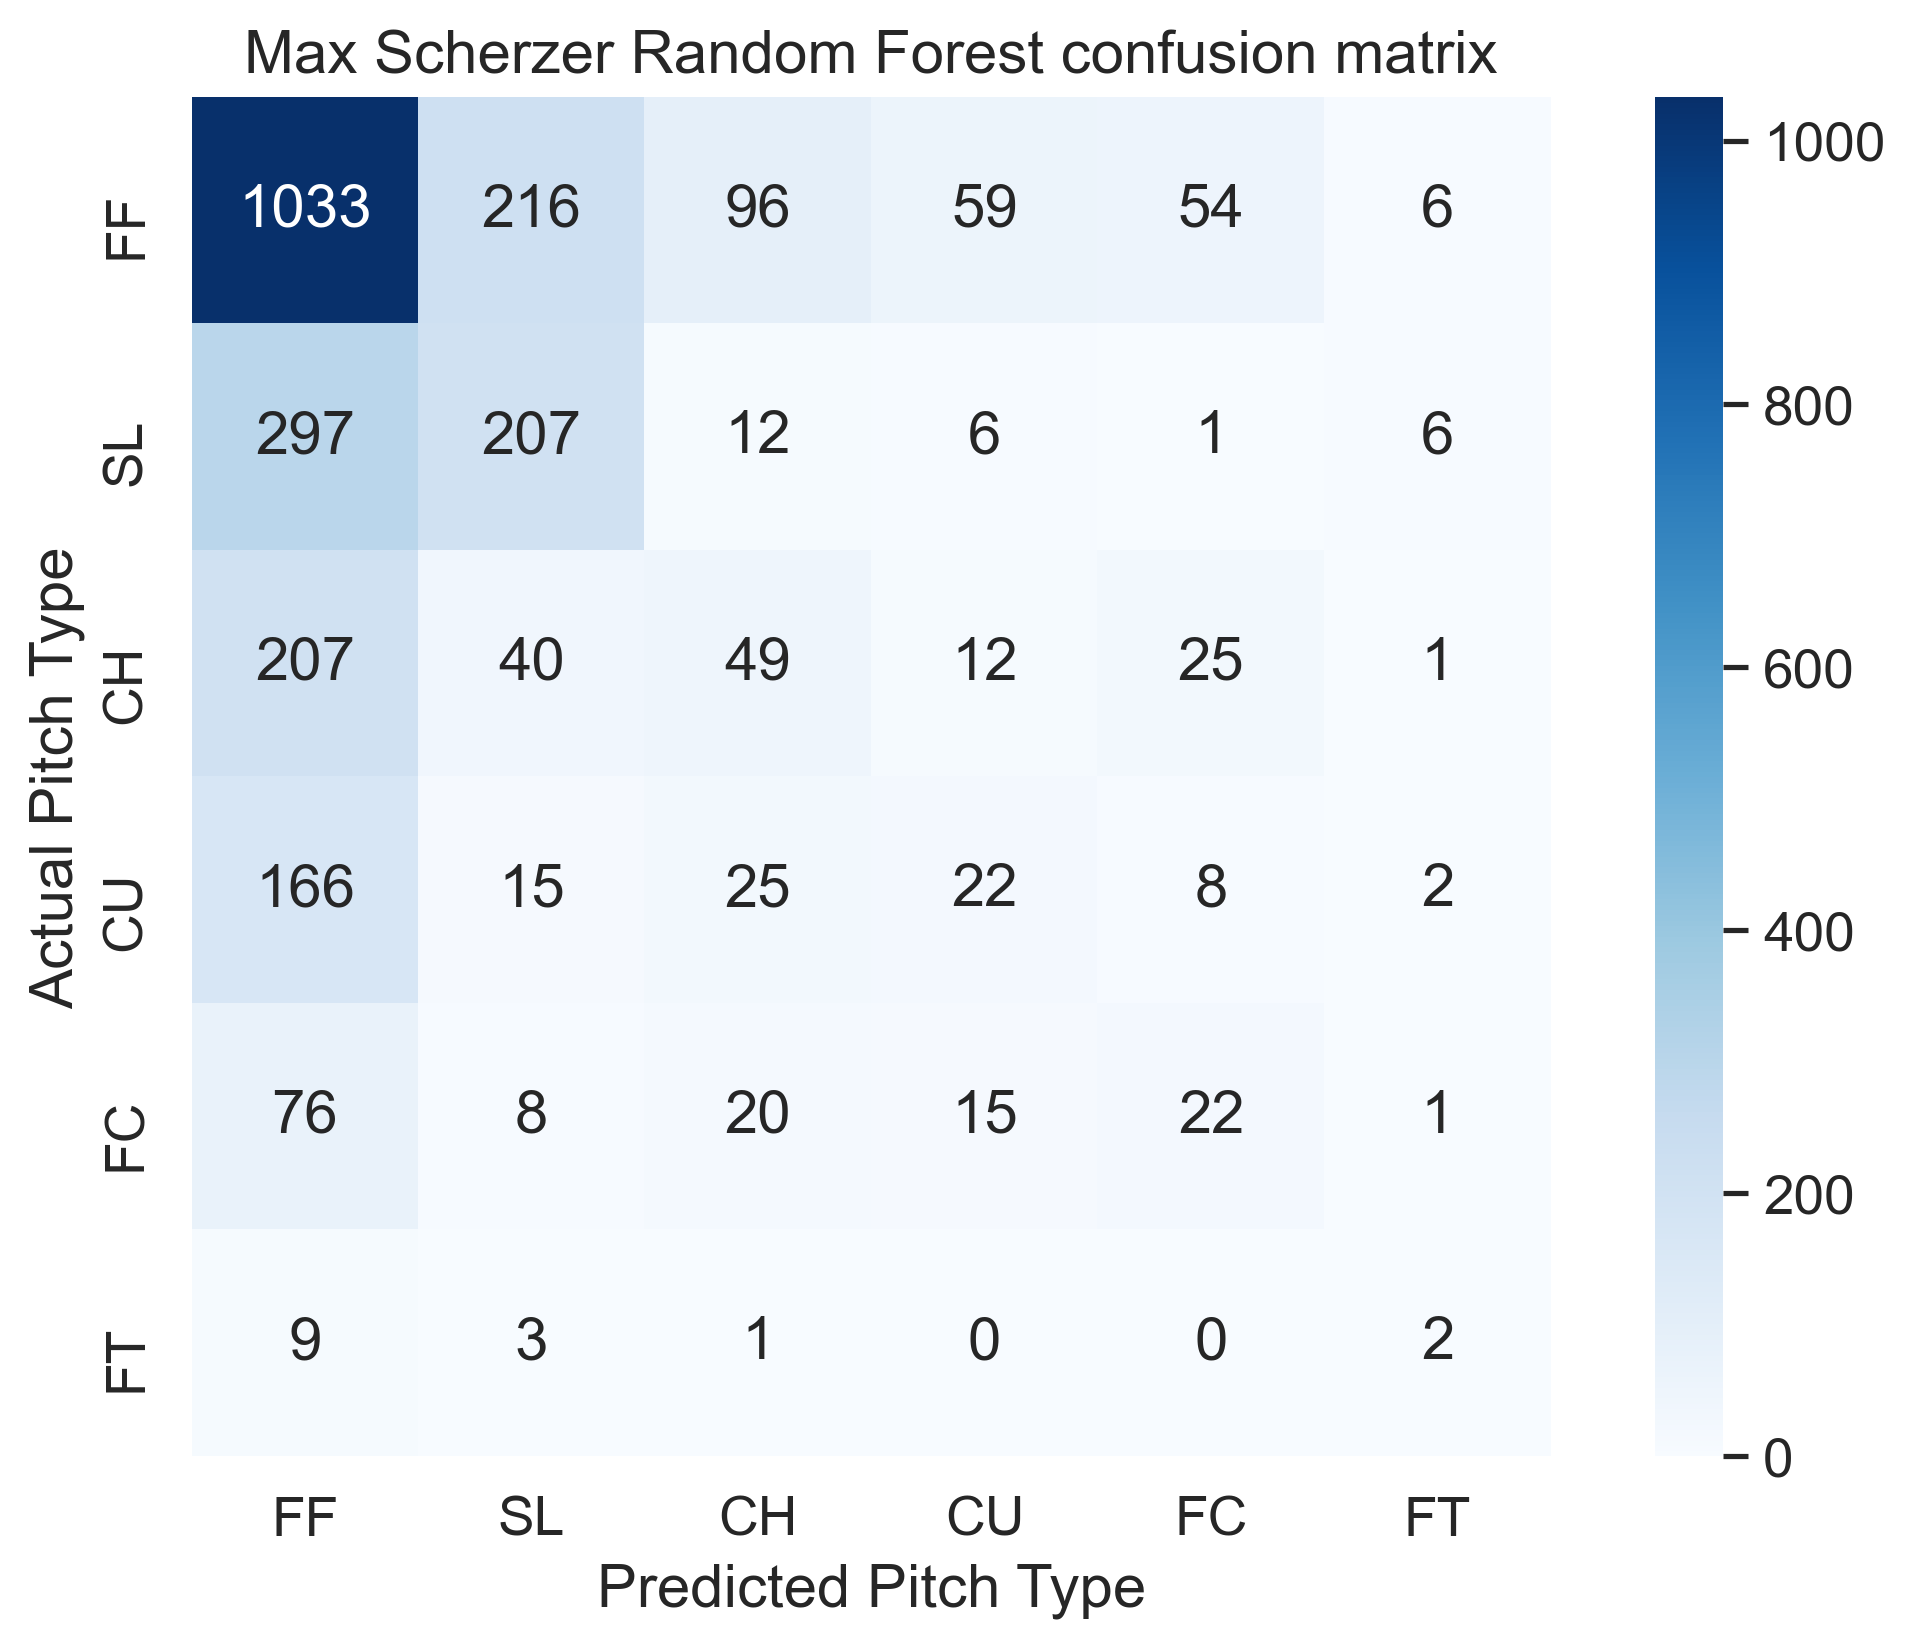

In [24]:
random_forest_eval_kfold_oversample('Max Scherzer',X,y, output_df,k=5)

That did offload more of the predictions onto the minority class, but still a lot of misses.

### Trying again with RA Dickey:

In [25]:
col = ['Cluster_1.0',
       'Cluster_2.0', 'Cluster_3.0', 'Cluster_4.0','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF',
       'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for R.A. Dickey
Precision scores: [0.46307215234102034]
Mean Precision: 0.46307215234102034
Confusion Matrix for Fold 1
[[1461   33    2]
 [ 198   38    0]
 [  37    1    0]]


Precision scores: [0.46307215234102034, 0.4473479284698421]
Mean Precision: 0.4552100404054312
Confusion Matrix for Fold 2
[[1446   44    3]
 [ 196   41    0]
 [  40    0    0]]


Precision scores: [0.46307215234102034, 0.4473479284698421, 0.48844176780119836]
Mean Precision: 0.46628728287068694
Confusion Matrix for Fold 3
[[1433   30    5]
 [ 209   48    1]
 [  44    0    0]]




/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision scores: [0.46307215234102034, 0.4473479284698421, 0.48844176780119836, 0.4778146273346134]
Mean Precision: 0.4691691189866685
Confusion Matrix for Fold 4
[[1444   36    0]
 [ 195   49    0]
 [  46    0    0]]


Precision scores: [0.46307215234102034, 0.4473479284698421, 0.48844176780119836, 0.4778146273346134, 0.4644975961216537]
Mean Precision: 0.46823481441366555
Confusion Matrix for Fold 5
[[1471   43    3]
 [ 172   46    0]
 [  35    0    0]]




RandomForestClassifier()

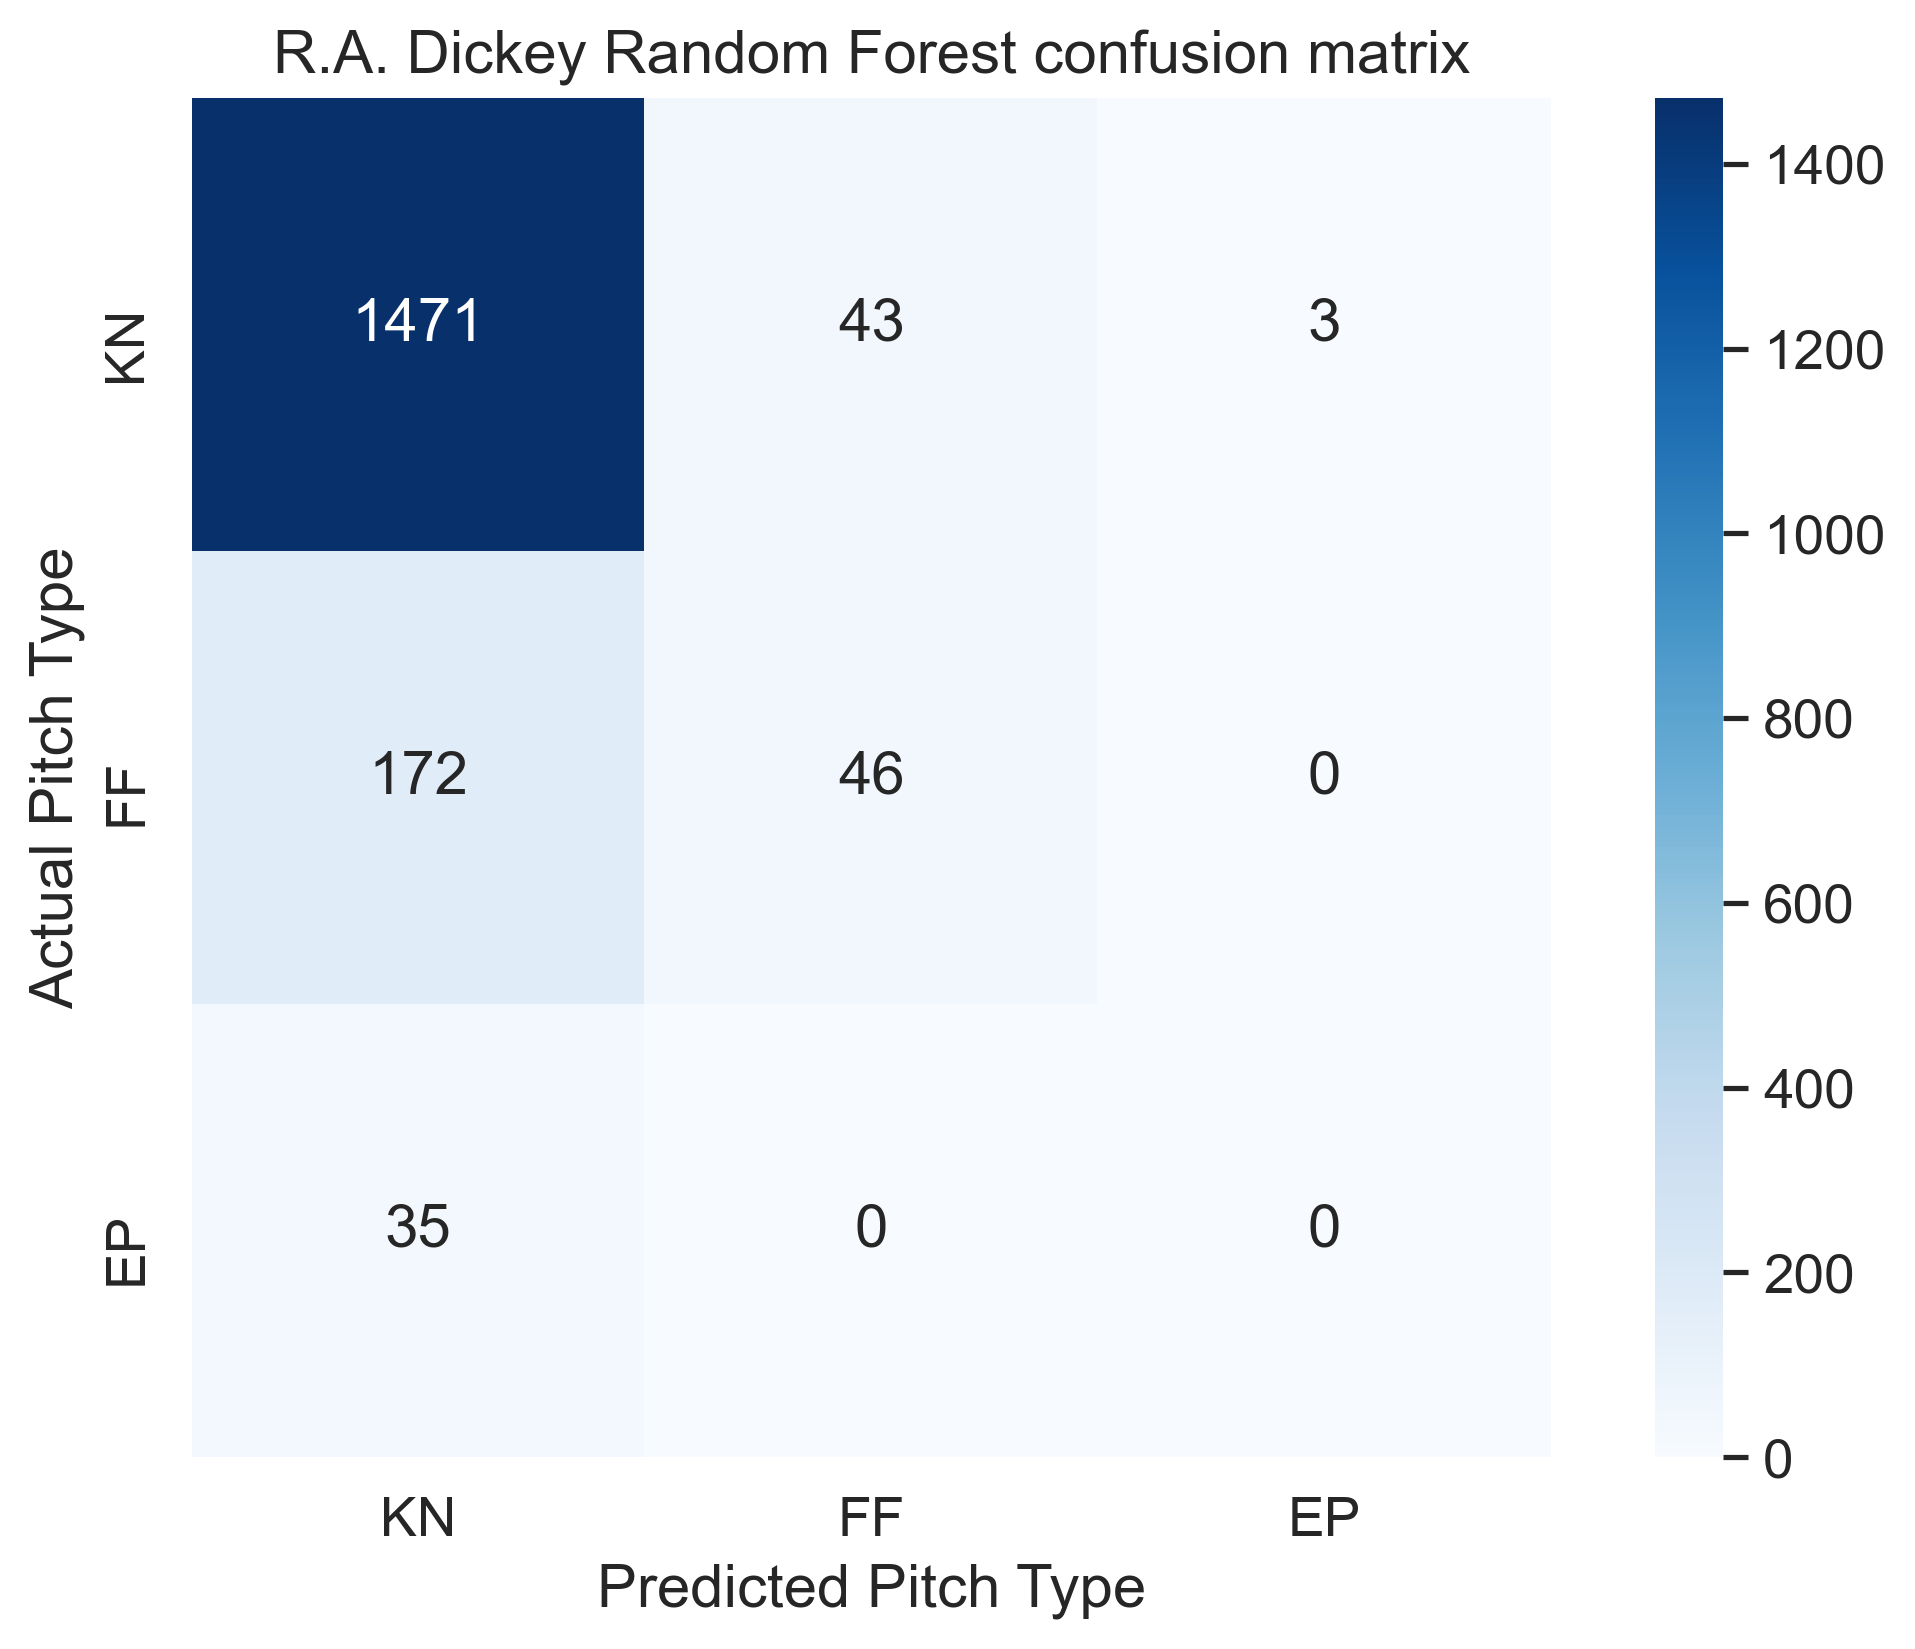

In [26]:
random_forest_pitch_pipeline_oversample('R.A. Dickey', pitch_df, ohe_cols, col, k=5)

### Lucas Giolito:

In [27]:
pitch_df[pitch_df.pitcher_full_name == 'Lucas Giolito'].last_pitch_type.value_counts()

FF    1993
CH     622
FT     583
SL     511
CU     485
Name: last_pitch_type, dtype: int64

In [28]:
col = ['Cluster_1.0',
       'Cluster_2.0', 'Cluster_3.0', 'Cluster_4.0','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_CU',
       'last_pitch_type_FF', 'last_pitch_type_FT', 'last_pitch_type_SL',
       'last_pitch_type_None',
       'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'FF': 0, 'CH': 1, 'FT': 2, 'SL': 3, 'CU': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Lucas Giolito
Precision scores: [0.3774721861254193]
Mean Precision: 0.3774721861254193
Confusion Matrix for Fold 1
[[265  37  26  31  18]
 [ 71  25  23   8  10]
 [ 45   6  47  10   4]
 [ 50  11   7  33   5]
 [ 51   6  18  15  17]]


Precision scores: [0.3774721861254193, 0.3369941089349714]
Mean Precision: 0.3572331475301953
Confusion Matrix for Fold 2
[[263  37  34  32  33]
 [ 59  25  22  10  10]
 [ 45  12  33  11   7]
 [ 57   8  13  27   7]
 [ 42  11  11  10  20]]


Precision scores: [0.3774721861254193, 0.3369941089349714, 0.35887437124279226]
Mean Precision: 0.3577802221010609
Confusion Matrix for Fold 3
[[278  36  34  31  25]
 [ 69  21  20   8   7]
 [ 54  15  34  17   5]
 [ 57   9   7  31   3]
 [ 36   7   7   8  20]]


Precision scores: [0.3774721861254193, 0.3369941089349714, 0.35887437124279226, 0.38171274961597546]
Mean Precision: 0.36376335397978954
Confusion Matrix for Fold 4
[[279  25  35  31  25]
 [ 75  24  18   2   1]
 [ 53  11  43  13   7]
 [ 45

RandomForestClassifier()

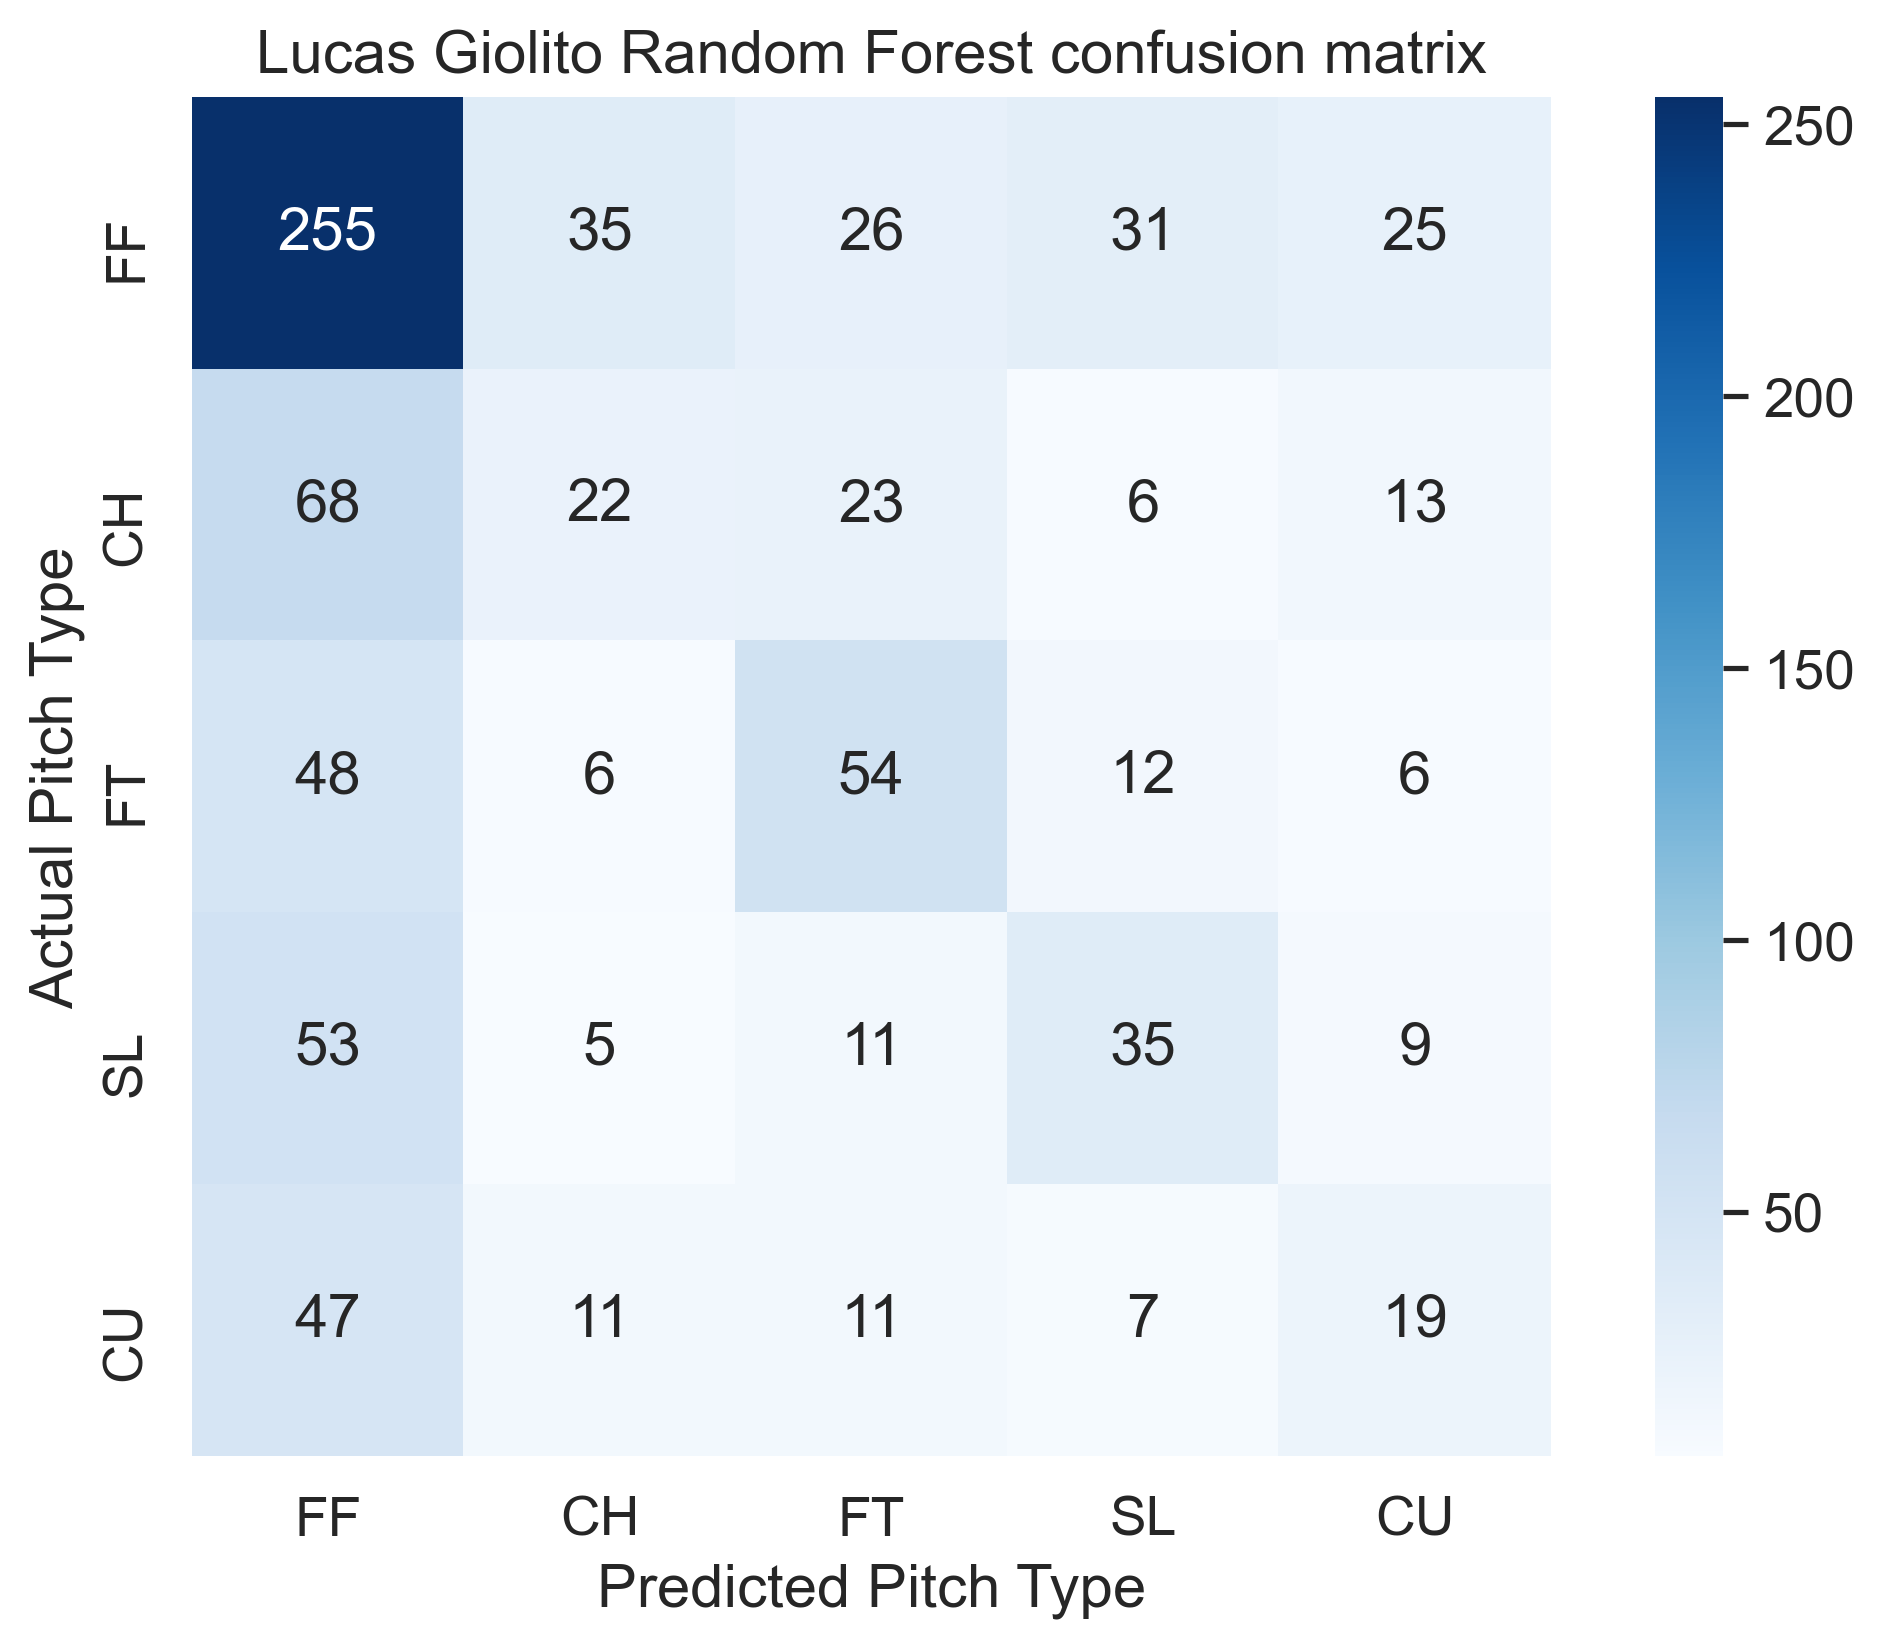

In [29]:
random_forest_pitch_pipeline_oversample('Lucas Giolito', pitch_df, ohe_cols, col, k=5)

# Error Analysis

Here I will be taking a look at some of the errors for the above pitchers, to see where the model can be improved.

### Max Scherzer:

In [30]:
col = ['Cluster_1.0',
       'Cluster_2.0', 'Cluster_3.0', 'Cluster_4.0','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

In [31]:
ohe_cols

['stand', 'p_throws', 'last_pitch_type', 'Cluster']

In [32]:
scherzer_ohe = column_ohe_maker(scherzer_df, ohe_cols)

In [33]:
scherzer_test = pitch_type_to_num(scherzer_ohe, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [34]:
X = scherzer_test[col]

In [35]:
y = scherzer_test['Pitch_Type_Num']

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

In [37]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

RandomForestClassifier()

Adding prediction probabilities, to see where the errors are:

In [38]:
val_df = X_val.copy()

In [39]:
y_pred = rf_model.predict_proba(X_val)

In [40]:
y_pred

array([[0.67, 0.02, 0.19, 0.1 , 0.01, 0.01],
       [0.83, 0.01, 0.08, 0.08, 0.  , 0.  ],
       [0.81, 0.04, 0.05, 0.07, 0.03, 0.  ],
       ...,
       [0.48, 0.24, 0.26, 0.01, 0.01, 0.  ],
       [0.51, 0.06, 0.15, 0.15, 0.06, 0.07],
       [0.5 , 0.44, 0.  , 0.04, 0.01, 0.01]])

In [47]:
pitch_type_list = val_df.pitch_type.value_counts().index
for i, pitch in pitch_type_list:
    col_name = pitch + '_prob'
col_name

AttributeError: 'DataFrame' object has no attribute 'pitch_type'

In [41]:
val_df['Prediction'] = rf_model.predict(X_val)
val_df['Pitch'] = y_val
val_df['FF_pred'] = y_pred[:,0]
val_df['SL_pred'] = y_pred[:,1]
val_df['CH_pred'] = y_pred[:,2]
val_df['CU_pred'] = y_pred[:,3]
val_df['FC_pred'] = y_pred[:,4]
val_df['FT_pred'] = y_pred[:,5]

val_df['diff_detector'] = val_df.Pitch - val_df.Prediction

Printing out the dataframe, where the prediction number did not match the pitch type thrown:

In [42]:
wrong_predictions = val_df[['Pitch','Prediction','diff_detector','FF_pred', 'SL_pred', 'CH_pred', 'CU_pred', 'FC_pred', 'FT_pred']][val_df.diff_detector != 0]

Diff_detector < 0 is when a more common pitch is thrown, but not predicted:

In [43]:
wrong_predictions.sort_values(by='diff_detector', ascending=True).head()

,Pitch,Prediction,diff_detector,FF_pred,SL_pred,CH_pred,CU_pred,FC_pred,FT_pred
1601713,0,5,-5,0.28,0.26,0.02,0.00,0.01,0.43
2147263,0,4,-4,0.36,0.01,0.10,0.06,0.47,0.00
2390492,0,4,-4,0.35,0.04,0.19,0.05,0.37,0.00
2089767,0,4,-4,0.25,0.05,0.16,0.09,0.45,0.00
1576597,0,4,-4,0.28,0.05,0.17,0.10,0.39,0.01


In [44]:
pitch_df.iloc[1601713, :]

inning                                  2
batter_id                          112526
pitcher_id                         453286
top                                     0
ab_id                         2.01705e+09
p_score                                 0
stand                                   R
p_throws                                R
event                           Strikeout
home_team                             atl
away_team                             was
b_score                                 2
on_1b                                   0
on_2b                                   0
on_3b                                   0
px                              0.0629456
pz                                3.30003
zone                                  2.0
pitch_type                             FF
start_speed                            93
type                                    S
b_count                                 1
s_count                                 0
outs                              

In [45]:
wrong_predictions.sort_values(by='diff_detector', ascending=False).head()

,Pitch,Prediction,diff_detector,FF_pred,SL_pred,CH_pred,CU_pred,FC_pred,FT_pred
1492989,5,0,5,0.51,0.06,0.15,0.15,0.06,0.07
1783802,5,0,5,0.50,0.05,0.09,0.21,0.07,0.08
1601658,5,0,5,0.35,0.20,0.06,0.21,0.13,0.05
1493084,5,0,5,0.76,0.16,0.06,0.02,0.00,0.00
1845708,5,0,5,0.33,0.07,0.15,0.18,0.06,0.21


In [46]:
pitch_df.iloc[1492989, :]

inning                                  1
batter_id                          624424
pitcher_id                         453286
top                                     0
ab_id                         2.01702e+09
p_score                                 4
stand                                   L
p_throws                                R
event                            Home Run
home_team                             nyn
away_team                             was
b_score                                 0
on_1b                                   0
on_2b                                   0
on_3b                                   0
px                                1.33759
pz                                  2.194
zone                                 14.0
pitch_type                             FT
start_speed                          95.2
type                                    B
b_count                                 0
s_count                                 0
outs                              